In [1]:
import time
import numpy as np
from constants import *
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

X = np.load('normalized_actions.npy')
y = np.load('normalized_labels.npy')

labels = np.unique(y)

le = LabelEncoder()
le.fit(y)
le_y = np.array(le.transform(y))
le_y = le_y.reshape((-1, 1))

ohe = OneHotEncoder()
ohe.fit(le_y)

y = ohe.transform(le_y).toarray()

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=2021)

In [3]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, Dense, ConvLSTM2D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import MaxPooling2D, Flatten, LSTM, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential(name="lstm_keras")
# model.add(Conv2D(32, (3, 3), strides=(1, 1),activation='relu', input_shape=(window_size, num_keypoints, 1)))
# model.add(MaxPooling2D(pool_size=2))
# model.add(Conv1D(64, (3,), strides=(1,),activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True,input_shape=(window_size, num_keypoints)))
model.add(LSTM(16, return_sequences=True, input_shape=(window_size, num_keypoints)))
model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))
model.summary()

Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 16)            2112      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 642       
Total params: 2,754
Trainable params: 2,754
Non-trainable params: 0
_________________________________________________________________


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

# callbacks_list_cnlst=[EarlyStopping(monitor='acc', patience=5),
#                       ModelCheckpoint(
#                                     filepath='cnn_lstm_model.h5',
#                                     monitor='val_loss',
#                                     save_best_only=True),
#                       ReduceLROnPlateau(monitor = "val_loss", factor = 0.1, patience = 3)
# ]
reduce_lr = ReduceLROnPlateau(monitor = "val_loss", verbose=1, patience = 3, factor=0.3, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_acc', mode='auto', verbose=1, patience=5, min_delta=.0001, baseline=None, restore_best_weights=True)

callbacks_list_cnlst = [reduce_lr]
init_lr = 0.2
model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=['acc', AUC(name='auc')])

In [5]:
epochs = 500
batch_size = 1

time_start = time.ctime()
start_time = time.time()
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                                    validation_data = (X_test, y_test),
                                    callbacks = callbacks_list_cnlst,
                    )
end_time = time.time()

 1s 6ms/step - loss: 0.1396 - acc: 0.9686 - auc: 0.9834 - val_loss: 0.1796 - val_acc: 0.9346 - val_auc: 0.9817 - lr: 1.0000e-06
Epoch 393/500
159/159 [==============================] - 1s 6ms/step - loss: 0.1396 - acc: 0.9686 - auc: 0.9834 - val_loss: 0.1796 - val_acc: 0.9346 - val_auc: 0.9817 - lr: 1.0000e-06
Epoch 394/500
159/159 [==============================] - 1s 6ms/step - loss: 0.1396 - acc: 0.9686 - auc: 0.9834 - val_loss: 0.1795 - val_acc: 0.9346 - val_auc: 0.9818 - lr: 1.0000e-06
Epoch 395/500
159/159 [==============================] - 1s 6ms/step - loss: 0.1395 - acc: 0.9686 - auc: 0.9835 - val_loss: 0.1795 - val_acc: 0.9346 - val_auc: 0.9818 - lr: 1.0000e-06
Epoch 396/500
159/159 [==============================] - 1s 6ms/step - loss: 0.1395 - acc: 0.9686 - auc: 0.9834 - val_loss: 0.1795 - val_acc: 0.9346 - val_auc: 0.9817 - lr: 1.0000e-06
Epoch 397/500
159/159 [==============================] - 1s 6ms/step - loss: 0.1396 - acc: 0.9686 - auc: 0.9833 - val_loss: 0.1794 - val

In [6]:
eval_loss, eval_acc, eval_auc = model.evaluate(X_test, y_test)
print("\nTraining at %s" % time_start)
print("Total run-time: %f (s)" % (end_time - start_time))
print("LOSS:", eval_loss)
print(" ACC:", eval_acc*100, "%")
print(" AUC:", eval_auc*100, "%")

4/4 [==============================] - 0s 3ms/step - loss: 0.1767 - acc: 0.9346 - auc: 0.9823

Training at Wed Mar 10 20:05:43 2021
Total run-time: 498.788888 (s)
LOSS: 0.17673422396183014
 ACC: 93.45794320106506 %
 AUC: 98.22691679000854 %


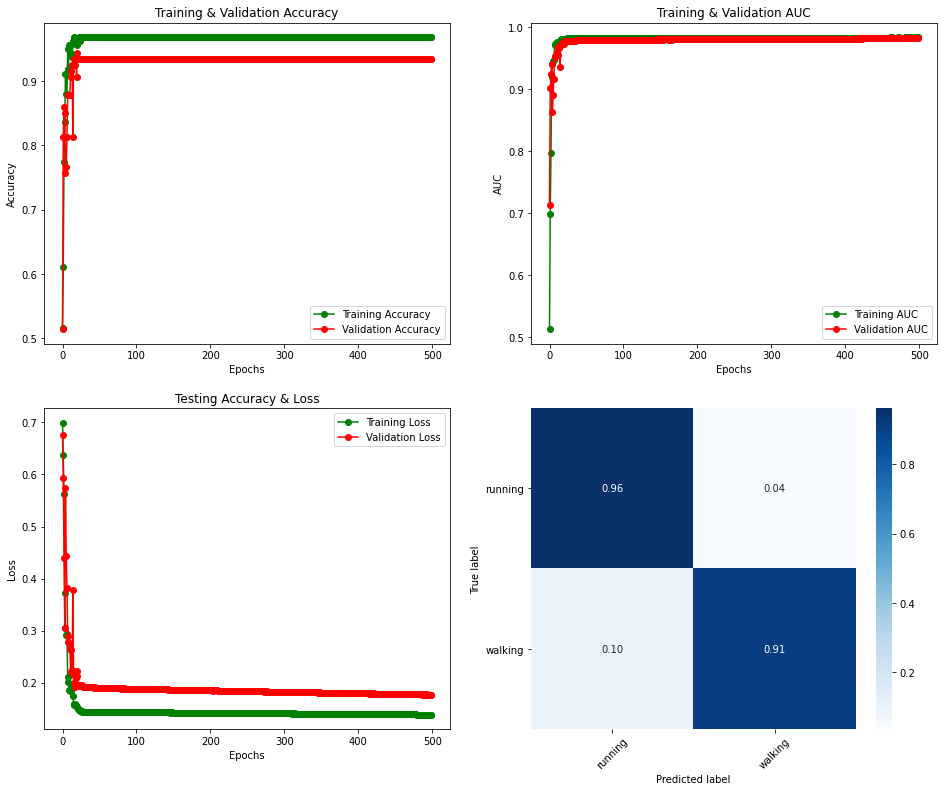

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Analysis after Model Training
dirname = 'plots'
epochs = [i for i in range(epochs)]
train_acc = history.history['acc']
train_auc = history.history['auc']
train_loss = history.history['loss']

val_acc = history.history['val_acc']
val_auc = history.history['val_auc']
val_loss = history.history['val_loss']

idx = 0
plt.rcParams['figure.figsize'] = (16, 13)
plt.subplots_adjust(hspace=0.2)

plt.subplot(2, 2, 1)
# plt.clf()
plt.plot(epochs, train_acc, 'go-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.savefig(dirname + '/' + "Acc_plot.png",
#             facecolor='w', transparent=False)

# plt.show()

plt.subplot(2, 2, 2)
# plt.clf()

plt.plot(epochs, train_auc, 'go-', label='Training AUC')
plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
plt.title('Training & Validation AUC')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("AUC")
# plt.savefig(dirname + '/' + "AUC_plot.png",
#             facecolor='w', transparent=False)
# plt.clf()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_loss, 'g-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation Loss')
plt.title('Testing Accuracy & Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.savefig(dirname + '/' + "Loss_plot.png",
#             facecolor='w', transparent=False)
# plt.clf()

plt.subplot(2, 2, 4)
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# print(train_data.class_indices)
cm = confusion_matrix(y_true, y_pred)
# print(cm)
cm = cm / cm.astype(np.float).sum(axis=1)
# print(cm)
g = sns.heatmap(cm, annot=True, fmt='.2f', cmap="Blues",
                xticklabels=labels, yticklabels=labels)
g.set_xticklabels(g.get_xticklabels(), ha='center', rotation=45)
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.ylabel("True label")
plt.xlabel("Predicted label")
figure = g.get_figure()
# figure.savefig(dirname + '/' + 'confusion_matrix.png',
#                 facecolor='w', transparent=False)
# plt.clf()


In [8]:
model.save("lstm_keras.h5")

In [9]:
from tensorflow.keras.models import load_model

model_loaded = load_model('lstm_keras.h5')

model_loaded.summary()

Model: "lstm_keras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 16)            2112      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 642       
Total params: 2,754
Trainable params: 2,754
Non-trainable params: 0
_________________________________________________________________
